## <ins>Pull Libraries </ins>

### Add Libraries to Environment

In [1]:
import Pkg
Pkg.add(["DataFrames",
        "LinearAlgebra",
        "EasyModelAnalysis",
        "CSV",
        "Dates"
        ])

    Updating registry at `C:\Users\A\.julia\registries\General.toml`
    Updating registry at `C:\Users\A\.julia\registries\JuliaSimRegistry.toml`
   Resolving package versions...
  No Changes to `C:\Users\A\Project.toml`
  No Changes to `C:\Users\A\Manifest.toml`


### Load Libraries

In [2]:
using DataFrames
using LinearAlgebra
using EasyModelAnalysis
using CSV
using Dates

[ Info: Precompiling EasyModelAnalysis [ef4b24a4-a090-4686-a932-e7e56a5a83bd]
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}, Tuple} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs\Docs.jl:240
  ** incremental compilation may be fatally broken for this module **

[ Info: Precompiling UnitfulLatexify [45397f5d-5981-4c77-b2b3-fc36d6e9b728]
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]


## <ins> Define Example Models for the Ensemble </ins>

### First Example Model

In [3]:
tspan = (0.0, 100.0)

(0.0, 100.0)

In [4]:
@parameters t β=0.1 c=10.0 γ=0.25 ρ=0.1 h=0.1 d=0.1 r=0.1
@variables S(t)=990.0 I(t)=10.0 R(t)=0.0 H(t)=0.0 D(t)=0.0
∂ = Differential(t)
N = S + I + R + H + D # This is recognized as a derived variable
eqs = [∂(S) ~ -β * c * I / N * S,
    ∂(I) ~ β * c * I / N * S - γ * I - h * I - ρ * I,
    ∂(R) ~ γ * I + r * H,
    ∂(H) ~ h * I - r * H - d * H,
    ∂(D) ~ ρ * I + d * H];

@named sys1 = ODESystem(eqs);

prob1 = ODEProblem(sys1, [], tspan);

### Second Example Model

In [19]:
@parameters t β=0.1 c=10.0 γ=0.25 ρ=0.1 h=0.1 d=0.1 r=0.1 v=0.1
@parameters t β2=0.1 c2=10.0 ρ2=0.1 h2=0.1 d2=0.1 r2=0.1
@variables S(t)=990.0 I(t)=10.0 R(t)=0.0 H(t)=0.0 D(t)=0.0
@variables Sv(t)=0.0 Iv(t)=0.0 Rv(t)=0.0 Hv(t)=0.0 Dv(t)=0.0
@variables I_total(t)

∂ = Differential(t)
N = S + I + R + H + D + Sv + Iv + Rv + Hv + Dv # This is recognized as a derived variable
eqs = [∂(S) ~ -β * c * I_total / N * S - v * Sv,
    ∂(I) ~ β * c * I_total / N * S - γ * I - h * I - ρ * I,
    ∂(R) ~ γ * I + r * H,
    ∂(H) ~ h * I - r * H - d * H,
    ∂(D) ~ ρ * I + d * H,
    ∂(Sv) ~ -β2 * c2 * I_total / N * Sv + v * Sv,
    ∂(Iv) ~ β2 * c2 * I_total / N * Sv - γ * Iv - h2 * Iv - ρ2 * Iv,
    ∂(Rv) ~ γ * I + r2 * H,
    ∂(Hv) ~ h2 * I - r2 * H - d2 * H,
    ∂(Dv) ~ ρ2 * I + d2 * H,
    I_total ~ I + Iv,
];

@named sys2 = ODESystem(eqs)
sys2 = structural_simplify(sys2)
prob2 = ODEProblem(sys2, [], tspan);

In [22]:
##Ensemble Problems
nprobs = [prob1,prob2]
function prob_func(prob, i, repeat)
    remake(nprobs[i])
end
enprob = EnsembleProblem(nprobs; prob_func)
sol = solve(enprob; saveat = 1, trajectories=2)

EnsembleSolution Solution of length 2 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, P, A, IType, DiffEqBase.Stats, Vector{Int64}} where {P, A, IType}

## <ins> Dataset Preprocessing </ins>

Download all 6 datasets from https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth. Make sure the datasets are in the same directory as this notebook

### Convert CSVs into DataFrames for Preprocessing

In [6]:
ds_nms = ["Cumulative_Cases",  
            "Cumulative_Deaths", 
            "Cumulative_Hospitalizations", 
            "Incident_Cases", 
            "Incident_Deaths", 
            "Incident_Hospitalizations"]

paths = ["$label.csv" for label in ds_nms]
dfs = map(x->DataFrame(CSV.File(x)), paths)

6-element Vector{DataFrame}:
 3641600×4 DataFrame
     Row │ date        location  location_name   value     
         │ Date        String7   String31        Int64     
─────────┼─────────────────────────────────────────────────
       1 │ 2020-01-22  01001     Autauga County          0
       2 │ 2020-01-23  01001     Autauga County          0
       3 │ 2020-01-24  01001     Autauga County          0
       4 │ 2020-01-25  01001     Autauga County          0
       5 │ 2020-01-26  01001     Autauga County          0
       6 │ 2020-01-27  01001     Autauga County          0
       7 │ 2020-01-28  01001     Autauga County          0
       8 │ 2020-01-29  01001     Autauga County          0
       9 │ 2020-01-30  01001     Autauga County          0
      10 │ 2020-01-31  01001     Autauga County          0
      11 │ 2020-02-01  01001     Autauga County          0
    ⋮    │     ⋮          ⋮            ⋮             ⋮
 3641591 │ 2023-02-23  US        United States   103363695
 364159

### Grab Data for a Single State

In [10]:
#Hospitalization needs to be sorted - date is not in increasing order
dfs[3] = sort(dfs[3], :date)
#Only care about the cumulative data so we take first 3 datasets
idxs = [1,2,3]
#Choose state to grab data from
row_nm = "New York"
#Preprocess datasets to only contain data from chosen state
dfs_state = [filter(row -> row["location_name"] in [row_nm],df) for df in dfs[idxs]]
#In order to ensure data shares time points, need to find their intersection across dates
common_values = intersect(dfs_state[1][!, "date"], dfs_state[2][!, "date"], dfs_state[3][!, "date"])
dfs_state_h = [filter(row -> row["date"] in common_values, df) for df in dfs_state]

3-element Vector{DataFrame}:
 108×4 DataFrame
 Row │ date        location  location_name  value   
     │ Date        String7   String31       Int64   
─────┼──────────────────────────────────────────────
   1 │ 2020-08-17  36        New York        428385
   2 │ 2020-08-18  36        New York        428923
   3 │ 2020-08-23  36        New York        432085
   4 │ 2020-08-24  36        New York        432558
   5 │ 2020-08-25  36        New York        433113
   6 │ 2020-08-26  36        New York        433595
   7 │ 2020-09-02  36        New York        438405
   8 │ 2020-09-03  36        New York        439322
   9 │ 2020-09-04  36        New York        440192
  10 │ 2020-09-06  36        New York        441748
  11 │ 2020-09-08  36        New York        442817
  ⋮  │     ⋮          ⋮            ⋮           ⋮
  99 │ 2021-03-10  36        New York       1713030
 100 │ 2021-03-12  36        New York       1724425
 101 │ 2021-03-13  36        New York       1734676
 102 │ 2021-03-15 

### Convert dates into time

In [11]:
#Need to create static index that maps dates to a day number starting from 0
day_since_start(date::Date, start_date::Date) = (date - start_date).value
dates = [dfs[i][dfs[i].location_name .== row_nm, :].date for i in idxs]
unique_dates = unique(sort(vcat(dates...)))
start_date = first(unique_dates)
end_date = last(unique_dates)
num_days = end_date - start_date
tss = map(x->day_since_start.(x, Ref(start_date)), getproperty.(dfs_state_h, Ref(:date)))

3-element Vector{Vector{Int64}}:
 [208, 209, 214, 215, 216, 217, 224, 225, 226, 228  …  413, 415, 416, 418, 419, 422, 424, 425, 427, 428]
 [208, 209, 214, 215, 216, 217, 224, 225, 226, 228  …  413, 415, 416, 418, 419, 422, 424, 425, 427, 428]
 [208, 209, 214, 215, 216, 217, 224, 225, 226, 228  …  413, 415, 416, 418, 419, 422, 424, 425, 427, 428]

In [12]:
#Get values at each time point
vals = getproperty.(dfs_state_h, Ref(:value))
data_dict = Dict()
map((nm,k,v)-> data_dict[nm] = Dict("ts"=>k, "vals"=>v),ds_nms,tss,vals)

3-element Vector{Dict{String, Vector{Int64}}}:
 Dict("vals" => [428385, 428923, 432085, 432558, 433113, 433595, 438405, 439322, 440192, 441748  …  1713030, 1724425, 1734676, 1748482, 1755193, 1772367, 1782769, 1785565, 1816518, 1825069], "ts" => [208, 209, 214, 215, 216, 217, 224, 225, 226, 228  …  413, 415, 416, 418, 419, 422, 424, 425, 427, 428])
 Dict("vals" => [32656, 32668, 32685, 32686, 32715, 32721, 32806, 32810, 32816, 32821  …  48369, 48554, 48648, 48815, 48908, 49134, 49226, 49244, 49517, 49589], "ts" => [208, 209, 214, 215, 216, 217, 224, 225, 226, 228  …  413, 415, 416, 418, 419, 422, 424, 425, 427, 428])
 Dict("vals" => [39321, 23385, 24276, 48148, 24809, 49265, 27722, 9270, 18059, 4162  …  40901, 40347, 24729, 6818, 35972, 46769, 637, 30985, 32601, 17853], "ts" => [208, 209, 214, 215, 216, 217, 224, 225, 226, 228  …  413, 415, 416, 418, 419, 422, 424, 425, 427, 428])

### Splitting Datasets

In [13]:
#Assigning dataset type to corresponding state 
I_nm = ds_nms[1]
D_nm = ds_nms[2]
H_nm = ds_nms[3]

"Cumulative_Hospitalizations"

In [14]:
#Train Data
train_idx = 30
t_train = tss[1][1:train_idx]
data_train = [
    I => data_dict[I_nm]["vals"][1:train_idx],
    D => data_dict[D_nm]["vals"][1:train_idx],
    H => data_dict[H_nm]["vals"][1:train_idx]
]

3-element Vector{Pair{Num, Vector{Int64}}}:
 I(t) => [428385, 428923, 432085, 432558, 433113, 433595, 438405, 439322, 440192, 441748  …  461537, 462861, 467693, 468840, 469989, 474894, 476397, 477671, 480129, 481227]
 D(t) => [32656, 32668, 32685, 32686, 32715, 32721, 32806, 32810, 32816, 32821  …  33158, 33166, 33221, 33234, 33241, 33291, 33296, 33299, 33320, 33330]
 H(t) => [39321, 23385, 24276, 48148, 24809, 49265, 27722, 9270, 18059, 4162  …  17985, 15207, 51421, 21197, 7883, 32927, 22343, 20634, 46238, 51230]

In [15]:
#Ensemble data
ensem_idx = 50
t_ensem = tss[1][1:ensem_idx]
data_ensem = [
    I => data_dict[I_nm]["vals"][1:ensem_idx],
    D => data_dict[D_nm]["vals"][1:ensem_idx],
    H => data_dict[H_nm]["vals"][1:ensem_idx]
]

3-element Vector{Pair{Num, Vector{Int64}}}:
 I(t) => [428385, 428923, 432085, 432558, 433113, 433595, 438405, 439322, 440192, 441748  …  523107, 530218, 533797, 537243, 541200, 561921, 566113, 570323, 579811, 609797]
 D(t) => [32656, 32668, 32685, 32686, 32715, 32721, 32806, 32810, 32816, 32821  …  33687, 33715, 33735, 33755, 33771, 33844, 33866, 33889, 34016, 34177]
 H(t) => [39321, 23385, 24276, 48148, 24809, 49265, 27722, 9270, 18059, 4162  …  13712, 16251, 51627, 39684, 37438, 15109, 21059, 34391, 33398, 9187]

In [16]:
#Forecast data
forcst_idx = 108 
t_forecast = tss[1][1:forcst_idx]
data_ensem = [
    I => data_dict[I_nm]["vals"][1:forcst_idx],
    D => data_dict[D_nm]["vals"][1:forcst_idx],
    H => data_dict[H_nm]["vals"][1:forcst_idx]
]

3-element Vector{Pair{Num, Vector{Int64}}}:
 I(t) => [428385, 428923, 432085, 432558, 433113, 433595, 438405, 439322, 440192, 441748  …  1713030, 1724425, 1734676, 1748482, 1755193, 1772367, 1782769, 1785565, 1816518, 1825069]
 D(t) => [32656, 32668, 32685, 32686, 32715, 32721, 32806, 32810, 32816, 32821  …  48369, 48554, 48648, 48815, 48908, 49134, 49226, 49244, 49517, 49589]
 H(t) => [39321, 23385, 24276, 48148, 24809, 49265, 27722, 9270, 18059, 4162  …  40901, 40347, 24729, 6818, 35972, 46769, 637, 30985, 32601, 17853]

## Calibrating Ensemble Model to Dataset

In [24]:
fitparams = map(nprobs) do prob
    global_datafit(prob, [β => [0.01, 10.0], γ => [0.01, 10.0]],
                            t_train, data_train)
end

function prob_func(prob, i, repeat)
    remake(nprobs[i]; p = fitparams[i], tspan = (t_train[1],t_train[end]))
end

fit_enprob = EnsembleProblem(nprobs; prob_func)
sol = solve(fit_enprob; trajectories=2);

### Visualize Results

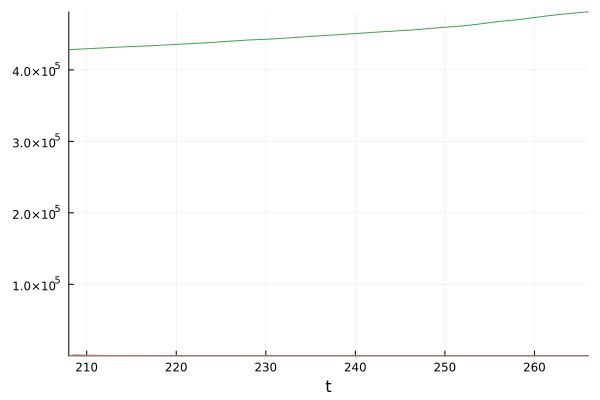

In [26]:
plot(sol;idxs = I)
plot!(t_train,data_train[1][2])